# Seminario de Ciencia de Datos - Trabajo práctico 2
### de la Fuente, Alethia- Hesse, Eugenia -  Baglivo, Fabricio

#### Configuraciones generales

In [2]:
from scipy.io import loadmat
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
import pandas as pd
import seaborn as sns
from scipy import stats
import os
from scipy import ndimage

#path de los archivos
path_to_files = 'F:\\Cursos Doctorado\\CienciaDeDatos\\2.SeriesTemporales\\datos\\'
#se crearon subcarpetas para los sujetos normales y los pacientes
p_to_files = path_to_files + 'p\\'
s_to_files = path_to_files + 's\\'

# caracteristicas de los datos
# dim 1 = epocas, dim 2 = electrodos, dim 3 = tiempo
# duracion de cada epoca 0.8 secs, 200 ms baseline
# 250 frecuencia de muestreo

epoch_time = 0.8

# 2. Ejercicios

## 2.1 Análisis de frecuencias

#### a) Computar uno de los posibles análisis espectrales.
* a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color.
#### Para realizar el análisis espectral se utilizará el método de Welch. Se calculará para cada trial de cada sujetos para los canales especificados.

In [4]:
selected_channels = [8,44,80,131,185] #canales especificados
selected_channels_indx = np.array(selected_channels) - 1 #indices de los canales especificados

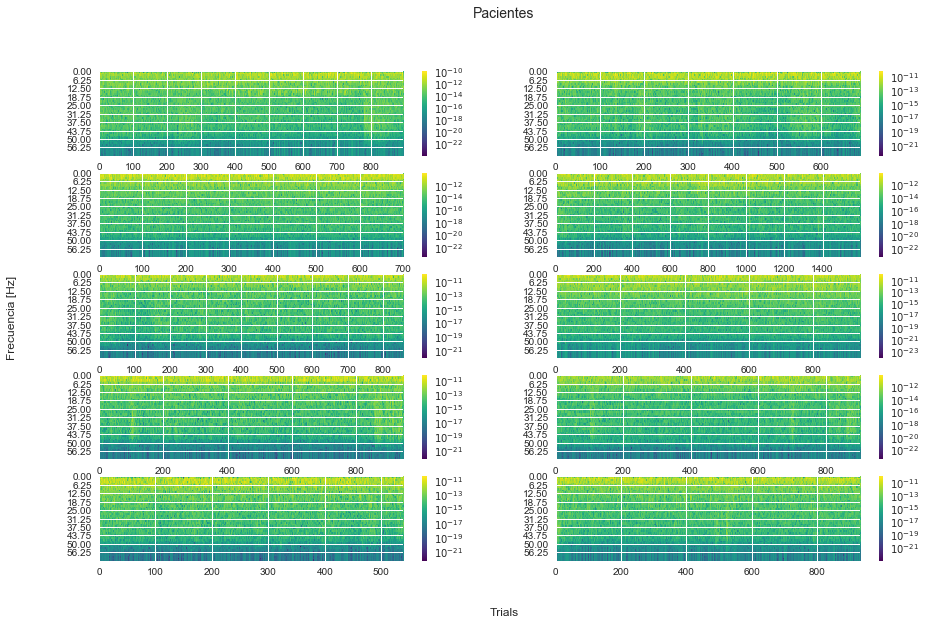

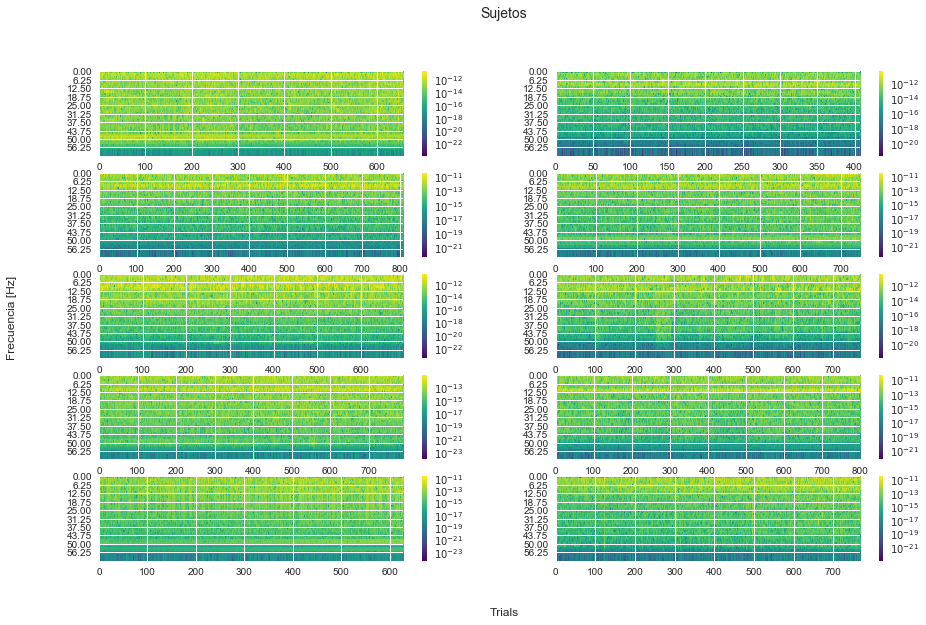

In [5]:
#definición de funciones utilizadas
def welch_by_trial(data,epoch_time):
    #calcula el espectro frecuencial de data (epochs,time)
    #devuelve un vector de frecuencias y una matriz con los resultados espectrales (frecuencias,trials)       
    pxx = np.empty([])    
    for trial in range(len(data)):           
        freq,e_pxx = welch(data[trial,:],fs = data.shape[1]/epoch_time, window='hamming')
        if trial == 0:
            pxx = np.empty((len(freq),len(data)))            
        pxx[:,trial] = e_pxx
         
    return [freq,pxx]


def welch_plot_for_subjects(path_to_files,sel_chans,epoch_time,plot_dim1,plot_dim2,title):
    #calcula el análisis espectral para todos los archivos dentro de una carpeta y los grafica
    files = os.listdir(path_to_files)  
    suj_nr = len(files)
    fig, axarr = plt.subplots(plot_dim1,plot_dim2, sharey=True)   
    
    for s_nr in range(0,suj_nr):           
        data = loadmat(path_to_files + files[s_nr])['data'] # epoch,electrodes,time
        grand_average = np.mean(data[:,sel_chans,:],1)
        [freq,pxx] = welch_by_trial(grand_average,epoch_time)
        #plot
        plt.subplot(plot_dim1,plot_dim2,s_nr+1)
        plt.imshow(pxx[:50,:],extent=[0,pxx.shape[1],freq[50],0],aspect='auto',cmap='viridis',norm=LogNorm(vmin=pxx.min(),vmax=pxx.max()))    
        plt.colorbar()
        plt.yticks(freq[range(0,50,5)])
    fig.text(0.5, 0.04, 'Trials', ha='center')
    fig.text(0.04, 0.5, 'Frecuencia [Hz]', va='center', rotation='vertical')    
    fig.suptitle(title, fontsize=14)
    fig.set_figwidth(15)
    fig.set_figheight(9)
    plt.show()         
    
plot_dim1 = 5
plot_dim2 = 2
welch_plot_for_subjects(p_to_files,selected_channels_indx,epoch_time,plot_dim1,plot_dim2,'Pacientes') #calculo para pacientes
welch_plot_for_subjects(s_to_files,selected_channels_indx,epoch_time,plot_dim1,plot_dim2,'Sujetos') #calculo para sujetos

* a.2) Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal.
#### Para realizar el análisis espectral se utilizará el método de Welch. Se calculará la media de trial para cada frecuencia de cada sujeto para todos los canales.

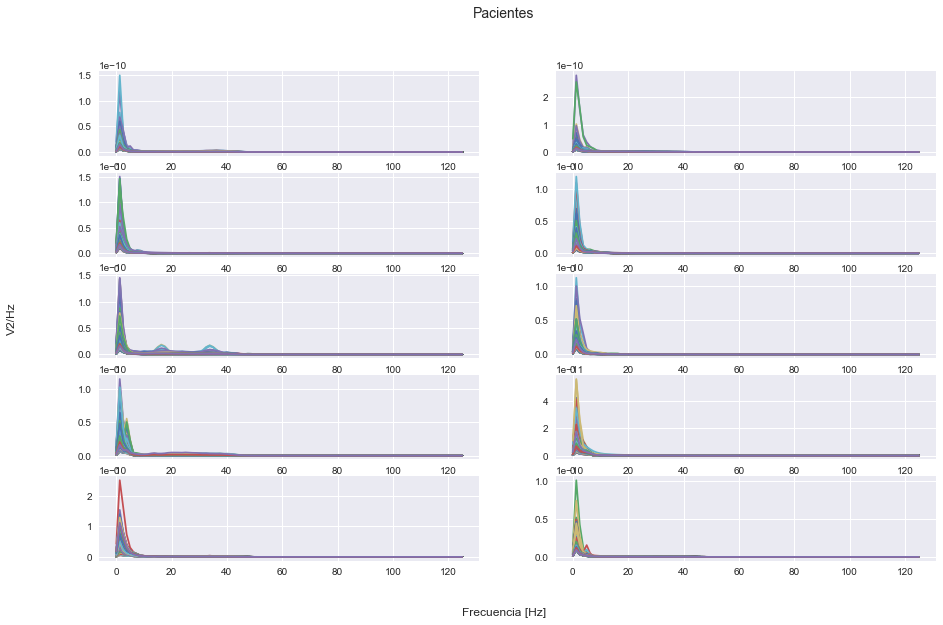

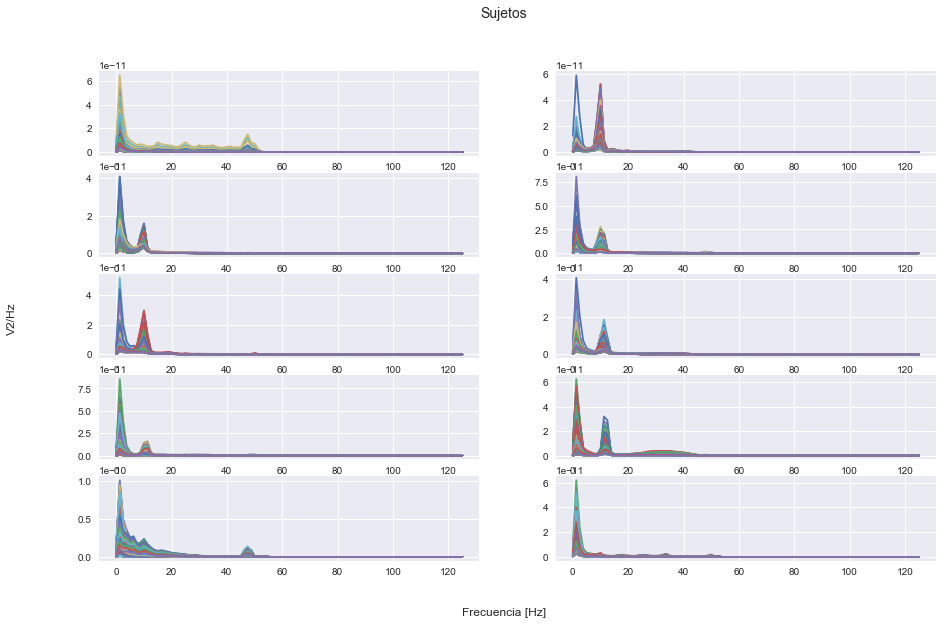

In [8]:
def welch_by_channel(file_path,epoch_time):
    #calcula el análisis espectral por trial por canal, y promedia por trials 
    data = loadmat(file_path)['data'] # epoch,electrodes,time
    channel_nr = data.shape[1]
    trial_nr = data.shape[0]
    pxx = np.empty([])
    for ch in range(0,channel_nr):
        chan_data = data[:,ch,:]
        [freq,ch_pxx] = welch_by_trial(chan_data,epoch_time)
        if ch == 0:
            pxx = np.empty((len(freq),trial_nr,channel_nr))
        pxx[:,:,ch] = ch_pxx            
    return [freq,pxx]

def welch_plot_by_channel_for_subjects(path_to_files,epoch_time,plot_dim1,plot_dim2,title):
    #grafica por canal el análisis espectral de cada archivo/sujeto dentro de una carpeta  
    files = os.listdir(path_to_files)  
    suj_nr = len(files)
    if suj_nr == 1:
        fig = plt.figure()
        [freq,pxx] = welch_by_channel(path_to_files + files[0],epoch_time)
        pxx_mean = np.mean(pxx,axis=1)   
        #plot        
        plt.plot(freq,pxx_mean)
    else:
        fig, axarr = plt.subplots(plot_dim1,plot_dim2, sharey=True)   
        for s_nr in range(0,suj_nr):        
            [freq,pxx] = welch_by_channel(path_to_files + files[s_nr],epoch_time)
            pxx_mean = np.mean(pxx,axis=1)   
            #plot
            plt.subplot(plot_dim1,plot_dim2,s_nr+1)
            plt.plot(freq,pxx_mean)
        
    fig.text(0.5, 0.04, 'Frecuencia [Hz]', ha='center')
    fig.text(0.04, 0.5, 'V2/Hz', va='center', rotation='vertical')    
    fig.suptitle(title, fontsize=14)
    fig.set_figwidth(15)
    fig.set_figheight(9)
    plt.show() 
    
welch_plot_by_channel_for_subjects(p_to_files,epoch_time,plot_dim1,plot_dim2,'Pacientes')    
welch_plot_by_channel_for_subjects(s_to_files,epoch_time,plot_dim1,plot_dim2,'Sujetos') 
    

* b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto.

In [3]:
def get_band_indexes(F,banda):
    Filter1 = abs(F-banda.min())
    c1 = Filter1.min()
    inddase1 = np.where(Filter1==c1)[0]
    Filter2 =abs(F-banda.max())
    c2 = Filter2.min()
    inddase2 = np.where(Filter2==c2)[0]
    return inddase1[0],inddase2[0]

def welch_freq_bands_for_subjects(path_to_files,epoch_time,group):
    #calcula las potencias for rangos de frecuencias utilizando el método de welch
        
    files = os.listdir(path_to_files)  
    suj_nr = len(files)    
    sujs_band_freqs = np.empty((suj_nr, 5))    
    for s_nr in range(0,suj_nr):  
        data = loadmat(path_to_files + files[s_nr])['data'] # epoch,electrodes,time
        grand_average = np.mean(data,1)
        [freq,pxx] = welch_by_trial(grand_average,epoch_time)
        
        #Se obtienen los indices de los rangos frecuenciales
        #Delta < 4 Hz
        deltai,deltaf = get_band_indexes(freq,np.array([0,4]))
        #4 Hz <= Theta < 8 Hz
        therai, theraf = get_band_indexes(freq,np.array([4,8]))
        #8 Hz <= Alpha < 13 Hz
        alphai,alphaf = get_band_indexes(freq,np.array([8,13]))
        #13 Hz <= Beta < 30 Hz
        betai,betaf = get_band_indexes(freq,np.array([13,30]))
        #30 Hz <= Gamma < Nyquist
        gammai,gammaf = get_band_indexes(freq,np.array([30,45]))
        
        #se promedian los valores espectrales para el rango de frecuencias por trial, y luego se promedian los trials 
        #para cada banda de frecuencia        
        sujs_band_freqs[s_nr,0]= np.mean(np.mean(pxx[range(deltai,deltaf),:],axis=0))
        sujs_band_freqs[s_nr,1]= np.mean(np.mean(pxx[range(therai,theraf),:],axis=0))
        sujs_band_freqs[s_nr,2]= np.mean(np.mean(pxx[range(alphai,alphaf),:],axis=0))
        sujs_band_freqs[s_nr,3]= np.mean(np.mean(pxx[range(betai,betaf),:],axis=0))
        sujs_band_freqs[s_nr,4]= np.mean(np.mean(pxx[range(gammai,gammaf),:],axis=0))

    sujs_band_freqs_df = pd.DataFrame({'Grupo' : group, 'Delta' : sujs_band_freqs[:,0],'Theta' : sujs_band_freqs[:,1],'Alpha' :sujs_band_freqs[:,2], 'Beta' : sujs_band_freqs[:,3],'Gamma' : sujs_band_freqs[:,4]})
    return sujs_band_freqs_df

p_freq_bands = welch_freq_bands_for_subjects(p_to_files,epoch_time,'p') #en este data frame se encuentran los valores de cada banda para cada paciente   
s_freq_bands = welch_freq_bands_for_subjects(s_to_files,epoch_time,'s') #en este data frame se encuentran los valores de cada banda para cada sujetos         


NameError: global name 'welch_by_trial' is not defined

* c) Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn. ¿Cuál recomendaría para graficar y comparar distribuciones?

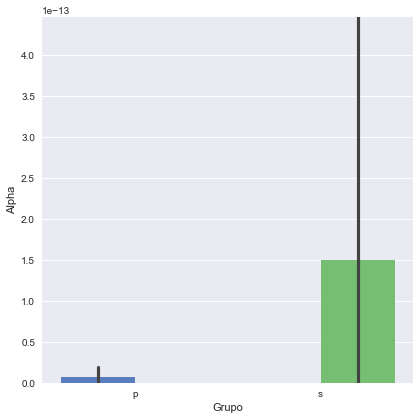

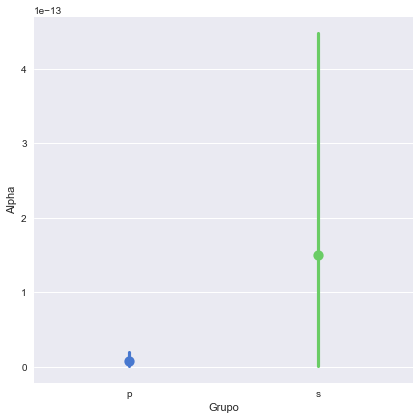

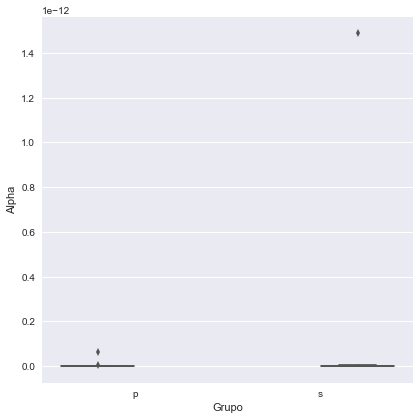

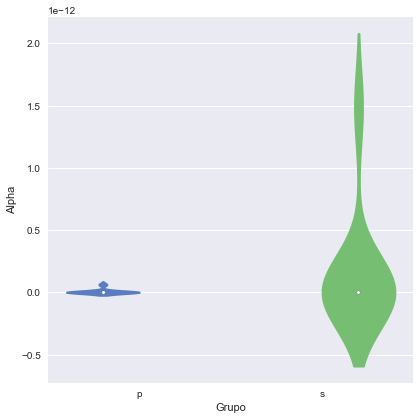

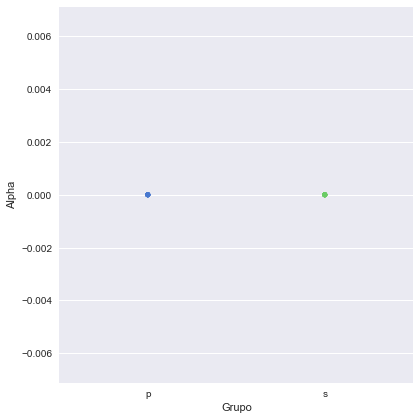

In [10]:
freq_bands = p_freq_bands.append(s_freq_bands,ignore_index=True)

g = sns.factorplot(x="Grupo", y="Alpha", hue="Grupo",size=6, kind="bar", palette="muted",data=freq_bands)
sns.plt.show()
g = sns.factorplot(x="Grupo", y="Alpha", hue="Grupo",size=6, kind="point", palette="muted",data=freq_bands)
sns.plt.show()
g = sns.factorplot(x="Grupo", y="Alpha", hue="Grupo",size=6, kind="box", palette="muted",data=freq_bands)
sns.plt.show()
g = sns.factorplot(x="Grupo", y="Alpha", hue="Grupo",size=6, kind="violin", palette="muted",data=freq_bands)
sns.plt.show()
g = sns.factorplot(x="Grupo", y="Alpha", hue="Grupo",size=6, kind="strip", palette="muted",data=freq_bands)
sns.plt.show()

#### El violin plot es el que recomendaríamos para comparar distribuciones.

* d) Para cada banda de frecuencia, graficar según lo elegido en el punto c) y realizar un test estadístico apropiado.



In [4]:
def exact_mc_perm_test2(xs, ys, nmc):
    n = len(xs)
    k=[]
    diff = np.mean(xs) - np.mean(ys)
    
    for j in range(nmc):
        zs = np.concatenate([xs, ys])
        np.random.shuffle(zs)
        k.append(np.mean(zs[:n]) - np.mean(zs[n:]))
    if diff > 0:
        return float(np.sum(k>diff))/float(nmc)
    else:
        return float(np.sum(k<diff))/float(nmc)

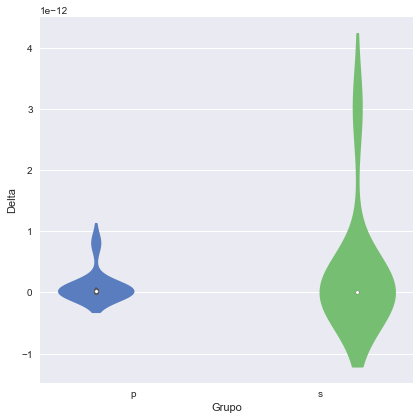

Delta P vs S: p=0.537 (permutaciones).


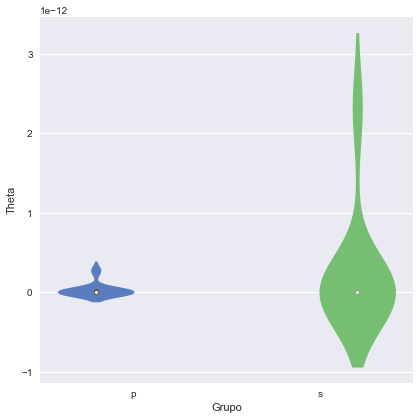

Theta P vs S: p=0.486 (permutaciones).


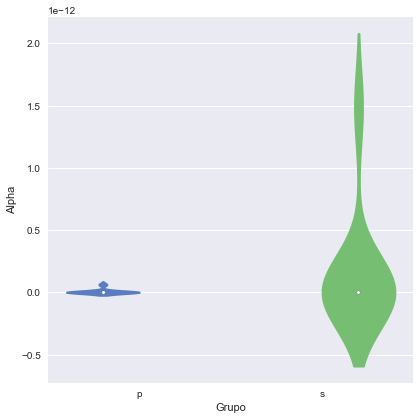

Alpha P vs S: p=0.361 (permutaciones).


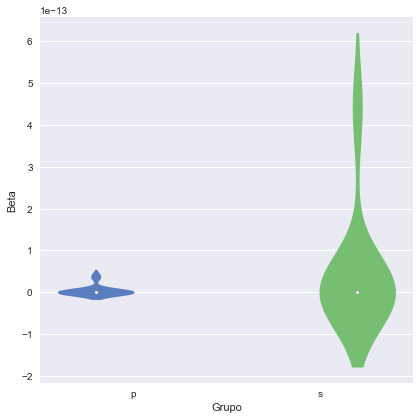

Beta P vs S: p=0.398 (permutaciones).


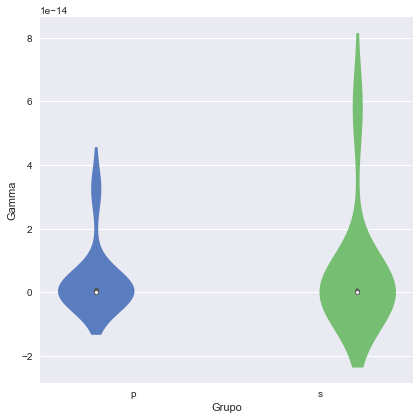

Gamma P vs S: p=0.44 (permutaciones).


In [15]:
# Permutaciones 
# Diferencias por bandas
#Delta: 
g = sns.factorplot(x="Grupo", y="Delta", hue="Grupo",size=6, kind="violin", palette="muted",data=freq_bands)
sns.plt.show()
p_delta = np.array(freq_bands.Delta[freq_bands.Grupo == 'p'])
s_delta = np.array(freq_bands.Delta[freq_bands.Grupo == 's'])
pperm_delta = exact_mc_perm_test2(p_delta,s_delta, 1000) 
print('Delta P vs S: p=' + str(pperm_delta)+ ' (permutaciones).')  

#Theta: 
g = sns.factorplot(x="Grupo", y="Theta", hue="Grupo",size=6, kind="violin", palette="muted",data=freq_bands)
sns.plt.show()
p_theta = np.array(freq_bands.Theta[freq_bands.Grupo == 'p'])
s_theta = np.array(freq_bands.Theta[freq_bands.Grupo == 's'])
pperm_theta = exact_mc_perm_test2(p_theta,s_theta, 1000) 
print('Theta P vs S: p=' + str(pperm_theta)+ ' (permutaciones).')  

#Alpha: 
g = sns.factorplot(x="Grupo", y="Alpha", hue="Grupo",size=6, kind="violin", palette="muted",data=freq_bands)
sns.plt.show()
p_alpha = np.array(freq_bands.Alpha[freq_bands.Grupo == 'p'])
s_alpha = np.array(freq_bands.Alpha[freq_bands.Grupo == 's'])
pperm_alpha = exact_mc_perm_test2(p_alpha,s_alpha, 1000) 
print('Alpha P vs S: p=' + str(pperm_alpha)+ ' (permutaciones).')   

#Beta: 
g = sns.factorplot(x="Grupo", y="Beta", hue="Grupo",size=6, kind="violin", palette="muted",data=freq_bands)
sns.plt.show()
p_beta = np.array(freq_bands.Beta[freq_bands.Grupo == 'p'])
s_beta = np.array(freq_bands.Beta[freq_bands.Grupo == 's'])
pperm_beta = exact_mc_perm_test2(p_beta,s_beta, 1000) 
print('Beta P vs S: p=' + str(pperm_beta)+ ' (permutaciones).')  

#Gamma: 
g = sns.factorplot(x="Grupo", y="Gamma", hue="Grupo",size=6, kind="violin", palette="muted",data=freq_bands)
sns.plt.show()
p_gamma = np.array(freq_bands.Gamma[freq_bands.Grupo == 'p'])
s_gamma = np.array(freq_bands.Gamma[freq_bands.Grupo == 's'])
pperm_gamma = exact_mc_perm_test2(p_gamma,s_gamma, 1000) 
print('Gamma P vs S: p=' + str(pperm_gamma)+ ' (permutaciones).')  

* e) Repetir los puntos b) y d) para los valores normalizados.



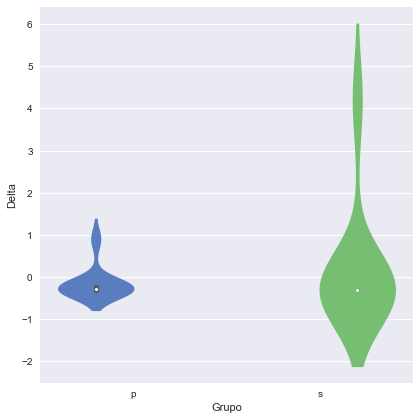

Delta Normalizado P vs S: p=0.479 (permutaciones).


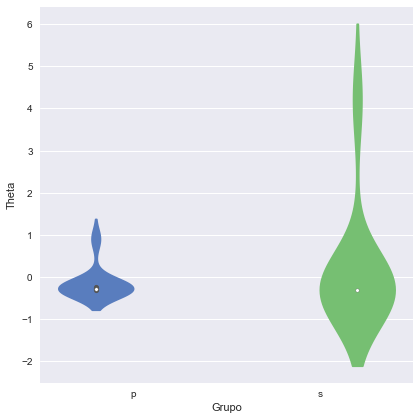

Theta Normalizado P vs S: p=0.488 (permutaciones).


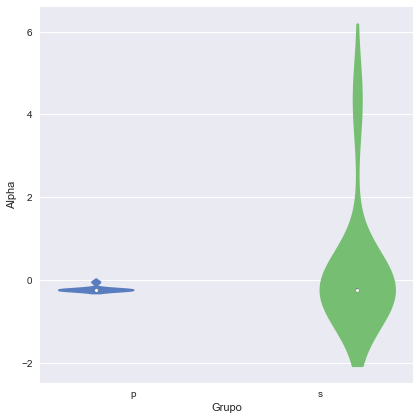

Alpha Normalizado P vs S: p=0.332 (permutaciones).


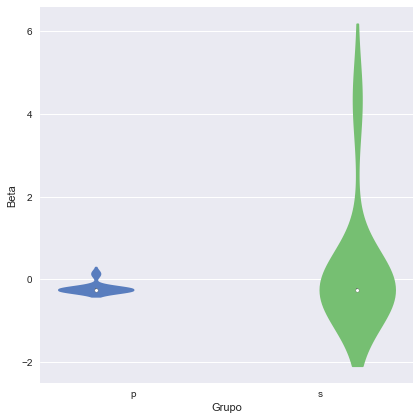

Beta Normalizado P vs S: p=0.431 (permutaciones).


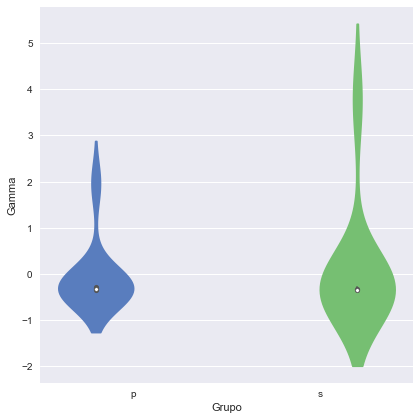

Gamma Normalizado P vs S: p=0.447 (permutaciones).


In [14]:
#Delta: 
delta_all_norm = stats.zscore(np.array(freq_bands.Delta))
delta_df = pd.DataFrame({'Grupo' : freq_bands.Grupo,'Delta':delta_all_norm})
g = sns.factorplot(x="Grupo", y="Delta", hue="Grupo",size=6, kind="violin", palette="muted",data=delta_df)
sns.plt.show()
delta_pperm = exact_mc_perm_test2(np.array(delta_df.Delta[freq_bands.Grupo == 'p']),np.array(delta_df.Delta[freq_bands.Grupo == 's']), 1000) 
print('Delta Normalizado P vs S: p=' + str(delta_pperm)+ ' (permutaciones).')     

#Theta: 
theta_all_norm = stats.zscore(np.array(freq_bands.Delta))
theta_df = pd.DataFrame({'Grupo' : freq_bands.Grupo,'Theta':theta_all_norm})
g = sns.factorplot(x="Grupo", y="Theta", hue="Grupo",size=6, kind="violin", palette="muted",data=theta_df)
sns.plt.show()
theta_pperm = exact_mc_perm_test2(np.array(theta_df.Theta[freq_bands.Grupo == 'p']),np.array(theta_df.Theta[freq_bands.Grupo == 's']), 1000) 
print('Theta Normalizado P vs S: p=' + str(theta_pperm)+ ' (permutaciones).') 

#Alpha: 
alpha_all_norm = stats.zscore(np.array(freq_bands.Alpha))
alpha_df = pd.DataFrame({'Grupo' : freq_bands.Grupo,'Alpha':alpha_all_norm})
g = sns.factorplot(x="Grupo", y="Alpha", hue="Grupo",size=6, kind="violin", palette="muted",data=alpha_df)
sns.plt.show()
alpha_pperm = exact_mc_perm_test2(np.array(alpha_df.Alpha[freq_bands.Grupo == 'p']),np.array(alpha_df.Alpha[freq_bands.Grupo == 's']), 1000) 
print('Alpha Normalizado P vs S: p=' + str(alpha_pperm)+ ' (permutaciones).')   

#Beta: 
beta_all_norm = stats.zscore(np.array(freq_bands.Beta))
beta_df = pd.DataFrame({'Grupo' : freq_bands.Grupo,'Beta':beta_all_norm})
g = sns.factorplot(x="Grupo", y="Beta", hue="Grupo",size=6, kind="violin", palette="muted",data=beta_df)
sns.plt.show()
beta_pperm = exact_mc_perm_test2(np.array(beta_df.Beta[freq_bands.Grupo == 'p']),np.array(beta_df.Beta[freq_bands.Grupo == 's']), 1000) 
print('Beta Normalizado P vs S: p=' + str(beta_pperm)+ ' (permutaciones).')   

#Gamma: 
gamma_all_norm = stats.zscore(np.array(freq_bands.Gamma))
gamma_df = pd.DataFrame({'Grupo' : freq_bands.Grupo,'Gamma':gamma_all_norm})
g = sns.factorplot(x="Grupo", y="Gamma", hue="Grupo",size=6, kind="violin", palette="muted",data=gamma_df)
sns.plt.show()
gamma_pperm = exact_mc_perm_test2(np.array(gamma_df.Gamma[freq_bands.Grupo == 'p']),np.array(gamma_df.Gamma[freq_bands.Grupo == 's']), 1000) 
print('Gamma Normalizado P vs S: p=' + str(gamma_pperm)+ ' (permutaciones).')    


## 2.2 Análisis de información

* a) Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.



In [5]:
def entropy_intra_electrode(data):
    #calcula la entropia por cada canal para cada trial
    entropy = np.empty((data.shape[0],data.shape[1]))
    for channel in range(data.shape[1]):            
        for trial in  range(data.shape[0]):
            zscored = stats.zscore(data[trial,channel,:])
            [n,bins] = np.histogram(zscored,bins=5)
#            [n,bins] = np.histogram(zscored)
            entropy[trial,channel] = stats.entropy(n)
              
    return entropy

def entropy_intra_electrode_for_subjects(path_to_files,selected_channels):
    #calcula la entropia para todos los sujectos/archivos en el directorio, para todos los canales y trials
    files = os.listdir(path_to_files)  
    suj_nr = len(files)
    entropy_for_sujs = np.empty((suj_nr))
    for s_nr in range(0,suj_nr):        
        data = loadmat(path_to_files + files[s_nr])['data'] # epoch,electrodes,time
        selected_data = data[:,selected_channels,:]        
        suj_entropy = entropy_intra_electrode(selected_data)
        entropy_for_sujs[s_nr] = np.mean(suj_entropy)
    return entropy_for_sujs



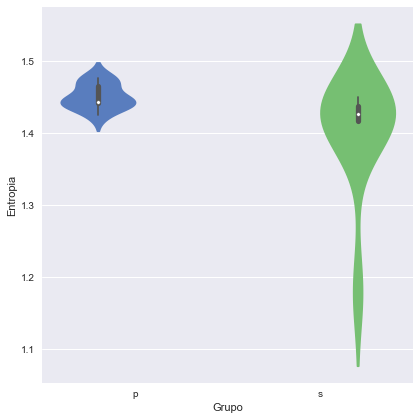

Entropia intra electrodos P vs S: p=0.0 (permutaciones).
Entropia intra electrodos P vs S: p=0.0081509715935 (ranksum).


In [6]:
selected_channels_indx = range(256)
p_entropy_sujs = entropy_intra_electrode_for_subjects(p_to_files,selected_channels_indx)
s_entropy_sujs = entropy_intra_electrode_for_subjects(s_to_files,selected_channels_indx)

p_intra_electrode_df = pd.DataFrame({'Grupo' : 'p','Entropia':p_entropy_sujs})
s_intra_electrode_df = pd.DataFrame({'Grupo' : 's','Entropia':s_entropy_sujs})
all_intra_electrode_df = p_intra_electrode_df.append(s_intra_electrode_df,ignore_index=True)
all_intra_electrode_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
g = sns.factorplot(x="Grupo", y="Entropia", hue="Grupo",size=6, kind="violin", palette="muted",data=all_intra_electrode_df)
sns.plt.show()

intra_electrode_pperm = exact_mc_perm_test2(np.array(all_intra_electrode_df.Entropia[all_intra_electrode_df.Grupo == 'p']),np.array(all_intra_electrode_df.Entropia[all_intra_electrode_df.Grupo == 's']), 1000) 
[tval1,pval1] = stats.ranksums(np.array(all_intra_electrode_df.Entropia[all_intra_electrode_df.Grupo == 'p']),np.array(all_intra_electrode_df.Entropia[all_intra_electrode_df.Grupo == 's']))
print('Entropia intra electrodos P vs S: p=' + str(intra_electrode_pperm)+ ' (permutaciones).')     
print('Entropia intra electrodos P vs S: p=' + str(pval1)+ ' (ranksum).')     


* b) Repetir el punto a) para una medida inter-electrodo.

In [7]:
EPS = np.finfo(float).eps

"""
 Taken from https://gist.github.com/GaelVaroquaux/ead9898bd3c973c40429
"""

def mutual_information_2d(x, y, sigma=1, normalized=False):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float    for subject in range(len(WAF)):   
        
        data_dict= loadmat('matfiles/' + WAF[subject] + '.mat')
        data=data_dict['data'] # epoch,electrodes,time
        
        mi=np.zeros((data.shape[0],data.shape[1],data.shape[1]),dtype=float)
        
        for trial in  range(1): #range(data.shape[0]):

            for channel in range(data.shape[1]):
                
                for channel2 in range(channel,data.shape[1]):
            
                    mi[trial,channel,channel2]=mutual_information_2d(data[trial,channel,:],data[trial,channel2,:])        
            
                    print(channel, channel2)
                    
                    
    mi2=mi[0,:,:]    
    plt.imshow(mi2) 
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

def mutual_information_inter_electrode_for_subjects(path_to_files,selected_channels):
    #calcula informacion mutual para todos los sujetos/archivos en un directorio, para todos los pares de canales y todos los trials
    files = os.listdir(path_to_files)  
    suj_nr = len(files)
    mean_mutual_information = np.empty((suj_nr))
    for s_nr in range(0,suj_nr):        
        data = loadmat(path_to_files + files[s_nr])['data'] # epoch,electrodes,time
        selected_data = data[:,selected_channels,:]    
        mi=np.zeros((data.shape[0],data.shape[1],data.shape[1]),dtype=float)
        for trial in  range(1): #range(selected_data.shape[0]):
            for channel in range(selected_data.shape[1]):                
                for channel2 in range(channel,selected_data.shape[1]):            
                    mi[trial,channel,channel2]=mutual_information_2d(selected_data[trial,channel,:],selected_data[trial,channel2,:])                    
        mean_mutual_information[s_nr] = np.mean(mi)                
        
    return mean_mutual_information

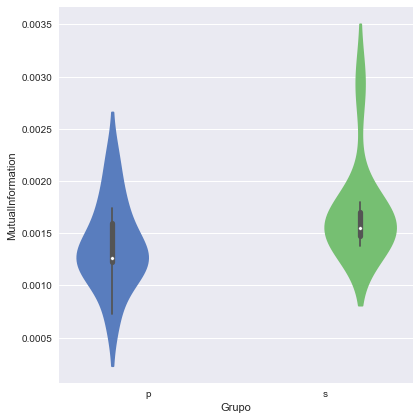

Informacion Mutua inter electrodos P vs S: p=0.048 (permutaciones).
Informacion Mutua inter electrodos P vs S: p=0.0493661947519 (ranksum).


In [8]:
selected_channels_indx = range(256)
p_mi = mutual_information_inter_electrode_for_subjects(p_to_files,selected_channels_indx)    
s_mi = mutual_information_inter_electrode_for_subjects(s_to_files,selected_channels_indx)   

p_inter_electrode_df = pd.DataFrame({'Grupo' : 'p','MutualInformation': p_mi})
s_inter_electrode_df = pd.DataFrame({'Grupo' : 's','MutualInformation': s_mi})
all_inter_electrode_df = p_inter_electrode_df.append(s_inter_electrode_df,ignore_index=True)

all_inter_electrode_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
g = sns.factorplot(x="Grupo", y="MutualInformation", hue="Grupo",size=6, kind="violin", palette="muted",data=all_inter_electrode_df)
sns.plt.show()
#print(all_inter_electrode_df.MutualInformation[all_inter_electrode_df.Grupo == 'p'])
#print(all_inter_electrode_df.MutualInformation[all_inter_electrode_df.Grupo == 's'])
inter_electrode_pperm = exact_mc_perm_test2(np.array(all_inter_electrode_df.MutualInformation[all_inter_electrode_df.Grupo == 'p']),np.array(all_inter_electrode_df.MutualInformation[all_inter_electrode_df.Grupo == 's']), 1000) 
print('Informacion Mutua inter electrodos P vs S: p=' + str(inter_electrode_pperm)+ ' (permutaciones).')     
[tval2,pval2] = stats.ranksums(np.array(all_inter_electrode_df.MutualInformation[all_inter_electrode_df.Grupo == 'p']),np.array(all_inter_electrode_df.MutualInformation[all_inter_electrode_df.Grupo == 's']))
print('Informacion Mutua inter electrodos P vs S: p=' + str(pval2)+ ' (ranksum).')     
